In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from venn import venn
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="upsetplot")
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset

# Load Dataset

In [334]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("nedjmaou/MLMA_hate_speech")

In [335]:
ds['train']

Dataset({
    features: ['HITId', 'tweet', 'sentiment', 'directness', 'annotator_sentiment', 'target', 'group'],
    num_rows: 18661
})

In [336]:
train = ds['train'].to_pandas()

# Assign language groups by row ranges
train['language'] = None
train.loc[:3352, 'language'] = 'arabic'      # 0 to 3352 (inclusive)
train.loc[3353:14646, 'language'] = 'english' # 3353 to 14646 (inclusive)
train.loc[14647:, 'language'] = 'french'      # 14647 to end

# Move 'language' to be the 3rd column
cols = list(train.columns)
cols.insert(2, cols.pop(cols.index('language')))
train = train[cols]

# Check the assignment
print(train['language'].value_counts(dropna=False))

train.head()

language
english    11294
french      4014
arabic      3353
Name: count, dtype: int64


,HITId,tweet,language,sentiment,directness,annotator_sentiment,target,group
0,1,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,arabic,hateful_normal,indirect,shock,gender,individual
1,2,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,arabic,offensive,indirect,anger_confusion_sadness_indifference_disgust,other,other
2,3,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,arabic,offensive,indirect,indifference,other,individual
3,4,@user @user انا اوافقك بخصوص السوريين و العراق...,arabic,normal,direct,indifference,origin,other
4,5,هذه السعودية التي شعبها شعب الخيم و بول البعير...,arabic,normal,indirect,indifference,origin,other


# Visualizations

## Sentiment Overlap

In [253]:
pd.set_option('display.max_rows', 10000)  # Show all rows in output

# Sentiment column needs to be cleaned

print(train['sentiment'].value_counts())

sentiment
offensive                                          8194
normal                                             3058
hateful                                            1297
abusive                                             615
offensive_hateful                                   554
abusive_offensive                                   422
abusive_hateful                                     378
offensive_disrespectful                             351
abusive_disrespectful                               351
disrespectful                                       329
fearful                                             304
offensive_normal                                    275
disrespectful_normal                                272
hateful_disrespectful                               240
abusive_normal                                      237
hateful_normal                                      182
fearful_abusive_offensive_hateful_disrespectful     176
abusive_offensive_hateful_disrespectfu

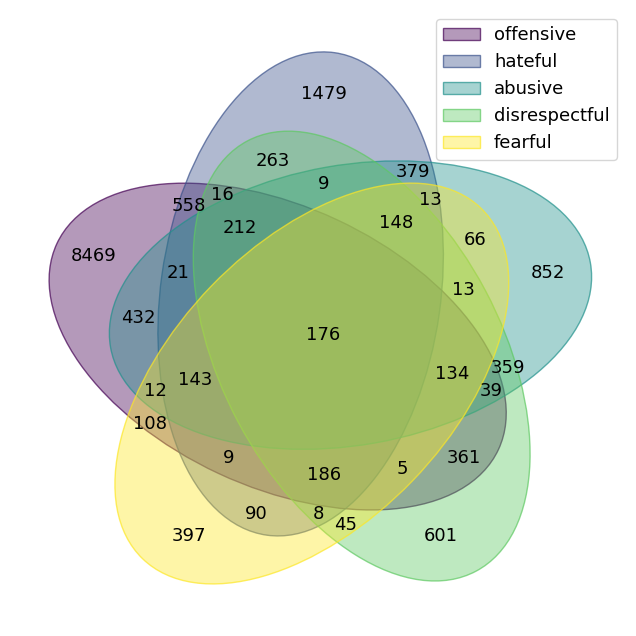

In [254]:
# Not recommended for 5 sets, but venn diagram for reference:

base_labels = ['offensive', 'hateful', 'abusive', 'disrespectful', 'fearful']

# Each set contains indices where the label appears anywhere in the sentiment string
venn_data = {
    label: set(train.index[train['sentiment'].str.contains(rf'{label}', regex=True)])
    for label in base_labels
}
venn(venn_data)
plt.show()

<Figure size 1000x800 with 0 Axes>

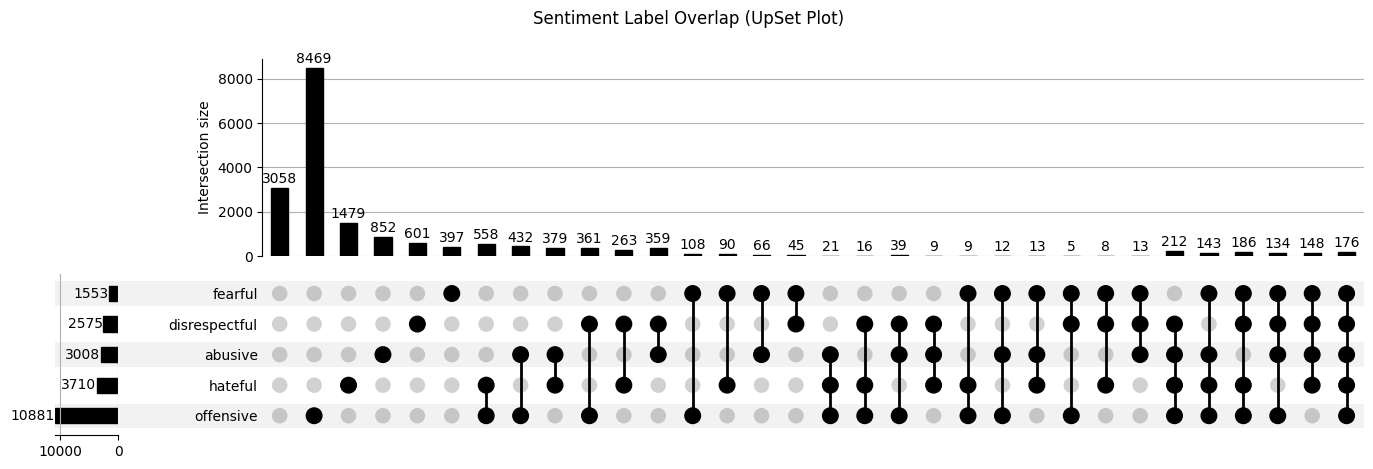

In [255]:
# base sentiment labels
base_labels = ['offensive', 'hateful', 'abusive', 'disrespectful', 'fearful']

# indicator columns for each base sentiment label
for label in base_labels:
    train[label] = train['sentiment'].str.contains(label)

# Upset data
upset_data = from_indicators(base_labels, train[base_labels])

plt.figure(figsize=(10,8))
UpSet(upset_data, subset_size='count', show_counts=True).plot()
plt.suptitle('Sentiment Label Overlap (UpSet Plot)')
plt.show()

In [367]:
# Only use the strongest label following the priority order 
def reduce_sentiment(sentiment):
    priority = ['abusive', 'hateful', 'offensive', 'disrespectful', 'fearful', 'normal']
    for label in priority:
        if label in sentiment.split('_'):
            return label
    return 'other'

train['sentiment_reduced'] = train['sentiment'].apply(reduce_sentiment)
print(train['sentiment_reduced'].value_counts())

sentiment_reduced
offensive        8943
normal           3058
abusive          3008
hateful          2609
disrespectful     646
fearful           397
Name: count, dtype: int64


## Number of Characters & Number of Words

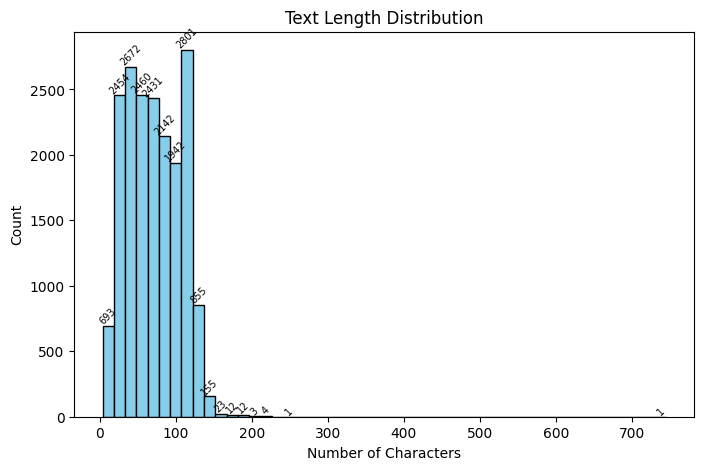

In [338]:
# --- Number of characters distribution ---
train['text_length'] = train['tweet'].astype(str).apply(len)
plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(train['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Count')

# Add value counts for the bins
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        plt.text((bin_left + bin_right) / 2, count, str(int(count)),
                 ha='center', va='bottom', fontsize=7, rotation = 45)

plt.show()

In [340]:
# Tweets with more than 150 characters

print(train['tweet'].where(train['text_length'] > 200).dropna().values)
train['tweet'] 

['Some cunt smashed my phone out my hand last night \\ud83e\\udd26\\ud83c\\udffd\\u200d\\u2640\\ufe0f\\ud83e\\udd26\\ud83c\\udffd\\u200d\\u2640\\ufe0f\\ud83e\\udd26\\ud83c\\udffd\\u200d\\u2640\\ufe0f\\ud83e\\udd26\\ud83c\\udffd\\u200d\\u2640\\ufe0f'
 '|\\uffe3\\uffe3\\uffe3\\uffe3\\uffe3\\uffe3\\uffe3\\uffe3\\uffe3\\uffe3 |\\n Stop using the words \\n \\u201cautism\\u201d and \\u201cretard\\u201d \\n as insults\\n|\\uff3f\\uff3f\\uff3f\\uff3f\\uff3f\\uff3f\\uff3f\\uff3f\\uff3f\\uff3f\\uff3f| \\n \\\\ (\\u2022\\u25e1\\u2022) /\\u2026 @URL'
 "@user Aww!!! Any guy who ain't good to you must be a retard!!! Just sayin!!! \\u2764\\ufe0f\\u2764\\ufe0f\\u2764\\ufe0f\\ud83c\\udf39\\ud83c\\udf39\\ud83c\\udf39\\ud83c\\udded\\ud83c\\uddf7\\ud83c\\udded\\ud83c\\uddf7\\ud83c\\udded\\ud83c\\uddf7"
 'How much do you hate that photo tho \\ud83d\\ude02\\ud83d\\ude02\\ud83d\\ude02\\ud83d\\ude02\\ud83d\\ude2d\\ud83d\\ude2d\\ud83d\\ude2d\\ud83d\\ude2d\\ud83d\\ude2d report harder mongy chops. I\\u2019ll jus

0        صلاة الفجر خير لك من ترديد بول البعير وسبي الن...
1        صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...
2        طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...
3        @user @user انا اوافقك بخصوص السوريين و العراق...
4        هذه السعودية التي شعبها شعب الخيم و بول البعير...
                               ...                        
18656    @user tres bien. le cinema francais c...est so...
18657    @user j’ai que des rebeus en demande d’amis aussi
18658                             @user sale juif de merde
18659    @user pourquoi tant de migrants africains en e...
18660    @user mdr c’est un mongol lui en mode lui dema...
Name: tweet, Length: 18661, dtype: object

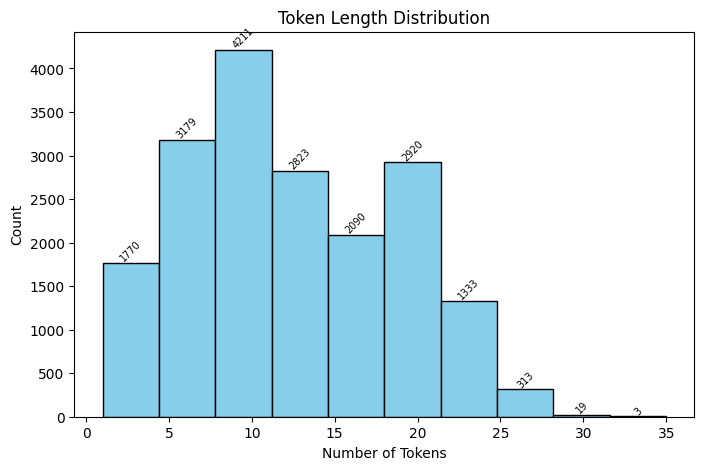

In [341]:
# If you want token length (for BERT), use:
train['token_length'] = train['tweet'].astype(str).apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(8, 5))
counts, bins, patches = ax.hist(train['token_length'], color='skyblue', edgecolor='black')
ax.set_title('Token Length Distribution')
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Count')

# Add value counts for the bins
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        ax.text((bin_left + bin_right) / 2, count, str(int(count)),
                ha='center', va='bottom', fontsize=7, rotation=45)

plt.show()

In [343]:
print(train['tweet'].where(train['token_length'] > 30).dropna().values)

['what the fuck is this ching chong siopao dimsum shit sa question 3 ???? cant understand cant c o n t e x t u a l i z e kasi it is so vague'
 'so i flipped that guy that i used to have a crush on off and now his best friend thinks he can fuck me. i\\u2019m dead.. fuck off you dumb cunt'
 'someone pls tell me why a 12 year old called me a ching chong bitch today when i looked at him funny for wearing a grill. i hate sb so much'
 "Well i got all my Facebooks bk on the one's i don't use but only 1 left to get bk on wudnt do date of birth Facebook is a fucking twat ugh"
 'Seaside is the worst map of all time dead ass all u do is get team shotted going B and A is is just retarded if u get the bomb plant down'
 'I don\\u2019t end work till 11 &amp; I\\u2019m over here hosting laughing at my phone. I look like a retard \\ud83d\\ude02\\ud83d\\udc80&amp; if you know me my laugh ain\\u2019t cute or quite']


### Clean Text

In [ ]:
# Replace unwanted chars
train['tweet_cleaned'] = train['tweet'].copy()
unwanted_chars = (
    r'@URL', r'@url', r'@user', r'\\ude02', r'\\ud83d', r'\\u2026', r'\\u201c', r'\\u201d', r'\\udc4d', r'\\n', r'\\uffe3', 
    r'\\ud83e', r'\\udd26', r'\\u2044', r'\\u25d5', r'\\udd26', r'\\u03c9', r'\\ud83c', r'\\udc80', r'\\udded', r'\\uddf7', 
    r'\\u2022', r'\\u25e1', r'\\udffd', r'\\u200d', r'\\u2640', r'\\ude37', r'\\udc40', r'\\ude1f', r'\\udd37', r'\\u2642', 
    r'\\ude2d', r'\\udd25', r'\\ude44', r'\\u2018', r'\\u2744', r'\\udff3', r'\\udf08', r'\\udc13', r'\\udd38', r'\\udc4a', 
    r'\\ude12', r'\\uddfa', r'\\uddf2', r'\\uded1', r'\\u25b7', r'\\u25c1', r'\\u2665', r'\\uff46', r'\\uff41', r'\\uff45', 
    r'\\uff54', r'\\udc47', r'\\udffb', r'\\ude05', r'\\udc4c', r'\\u270b', r'\\udeab', r'\\udfe2', r'\\uddf9', r'\\ude08', 
    r'\\udc3e', r'\\ude03', r'\\udca3', r'\\ude0e', r'\\udd23', r'\\udd95', r'\\udf33', r'\\ude1a', r'\\udf8a', r'\\udd2a',
    r'\\u2800', r'\\u275b', r'&amp', r'&gt;', r'&lt;'
)

train['tweet_cleaned'] = train['tweet_cleaned'].str.replace(r'\\u2019', "'", case=False, regex=True) #apostraphes

for char in unwanted_chars:
    train['tweet_cleaned'] = train['tweet_cleaned'].str.replace(char, " ", case=False, regex=True)

train['tweet_cleaned'] = train['tweet_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))


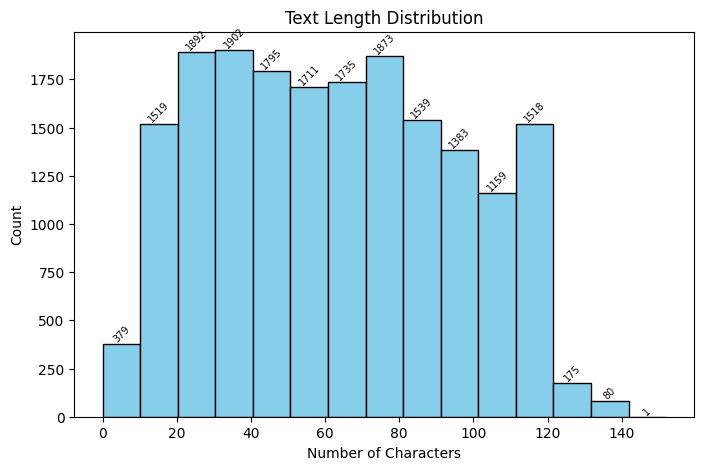

In [387]:
# --- Number of characters distribution ---
train['text_length'] = train['tweet_cleaned'].astype(str).apply(len)
plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(train['text_length'], bins=15, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Count')

# Add value counts for the bins
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        plt.text((bin_left + bin_right) / 2, count, str(int(count)),
                 ha='center', va='bottom', fontsize=7, rotation = 45)

plt.show()

In [352]:
print(train['tweet_cleaned'].where(train['text_length'] > 135).dropna().values)

['مدينة بورنهايم بالـ المانيا تمنع اللاجئين العرب والمسلمين البالغين من دخول بركة السباحة العامة بعد تلقي شكاوي من نساء المانيات تم التحرش بهن'
 'خنازير العرب من الخونة ودعاة الرذيلة والفساد يزعمون انهم هاجروا الى الغرب والهجرة تكون من بلاد الكفر الى ديار الاسلام وصفهم الحقيقى خنازير'
 'يا ليت يحكمنا ذئاب ولذئاب اخلاق،،لكن ما يحكمنا خنازير معفنة #يقتلون اهلنا بالموصل حاضرة الاسلام بعد الفلوجة وحلب ودمشق #بلاد الهلال الخصيب'
 'ده مثال ،والأطفال هناك عارفة حقوقها كويس ،بيتعلموها في المدارس ،زي ما بيتعلموا تربية جنسية وازاي يفرق بين اللمس العادي واللمسة الغلط التحرش'
 'لقدمضى على ايقاف حملة الاجرام الصليبية على الشعب السوري بعد ان تم عقد المصالحات وتسليم ماتم تحريره لقوات احتلال فهل شاهدنا اللاجئون بطوابير'
 'بعد مباراه الاتفاق التوقف 56 يوم يعني يمدي نطرد ابو شعر وصح ونجيب واحد جهه متسفط عصبي لا يصلي ولا يصوم اذا ما اكل لحم خنزير تصكه النفسيه'
 'ليست(فاسقةً أو فاجرة او عاهرة) لمجرد أنها متبرجة نعم هى معصية لكن لا علاقة لها بعفتهاوطهرها ليس كل من أتى معصية يصبح مهدر الحق مستباح العرض'
 'م

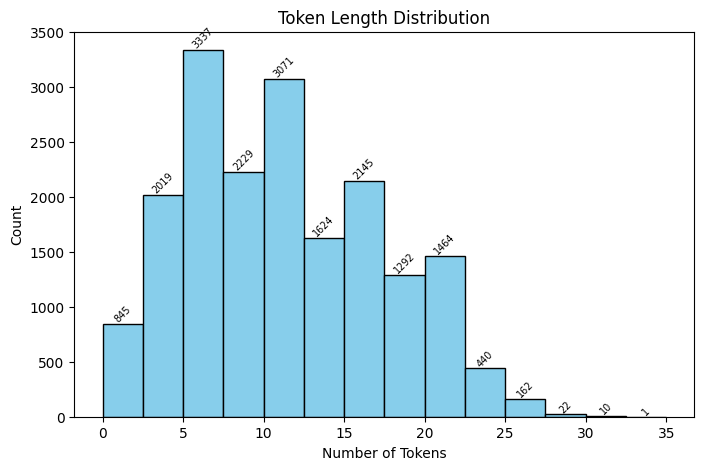

In [388]:
# If you want token length (for BERT), use:
train['token_length'] = train['tweet_cleaned'].astype(str).apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(8, 5))
counts, bins, patches = ax.hist(train['token_length'], bins=14, color='skyblue', edgecolor='black')
ax.set_title('Token Length Distribution')
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Count')

# Add value counts for the bins
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        ax.text((bin_left + bin_right) / 2, count, str(int(count)),
                ha='center', va='bottom', fontsize=7, rotation=45)

plt.show()

In [364]:
print(train['tweet_cleaned'].where(train['token_length'] > 28).dropna().values)

['ملاحظة حتى انه تعلق على بنت انها سمينة او شنعة او جسمها مش متناسق او شعرها خشن هذا بندرج تحت التحرش لانه مش شرط التحرش اللفظي يكون كلمات غزل'
 'مش عايز احبط حد بس بعد ما سافرت و شوفت الحريم اللي بجد اجانب و عرب و كدا اكتشفت ان الحريم المصرية هم سبب النكد و سبب الوفاه المبكر'
 'القبول حاجة مش بإيدينا يا جماعة والله ومش شرط إنه يكون الشخص وحش لا خالص هو احساس بييجي لوحده ومش سهل إنه يتغير هو مش زرار هندوس عليه يعني'
 'what the fuck is this ching chong siopao dimsum shit sa question 3 ???? cant understand cant c o n t e x t u a l i z e kasi it is so vague'
 "As a kid I would've hated to have moved to a different part of the country but as an adult I can't wait to get away from the shithole"
 'i stg when i was younger i used to be mad stupid. my mental state was why do people die just keep your eyes open ong i was retarded.'
 'Who tf adds someone to a gc full of latinx so they can call them nigger and be pieces of shit? To get beat tf up by the WRONG ONE'
 "Mid 40's smelly psy blk mom tr

## Distributions

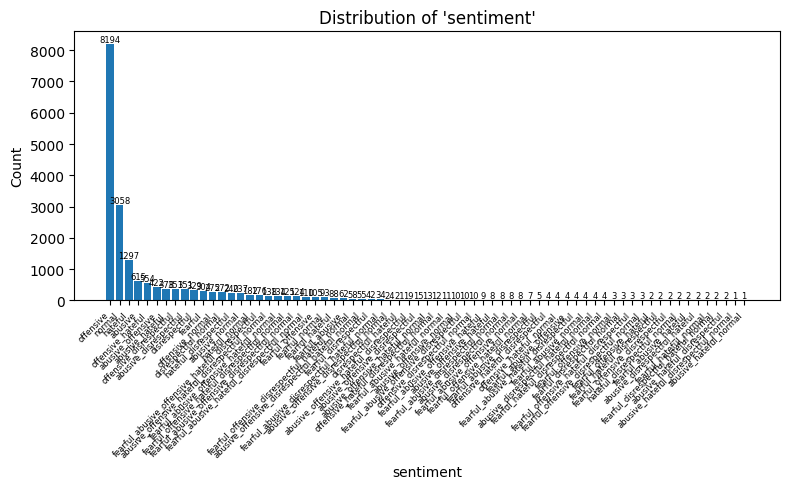

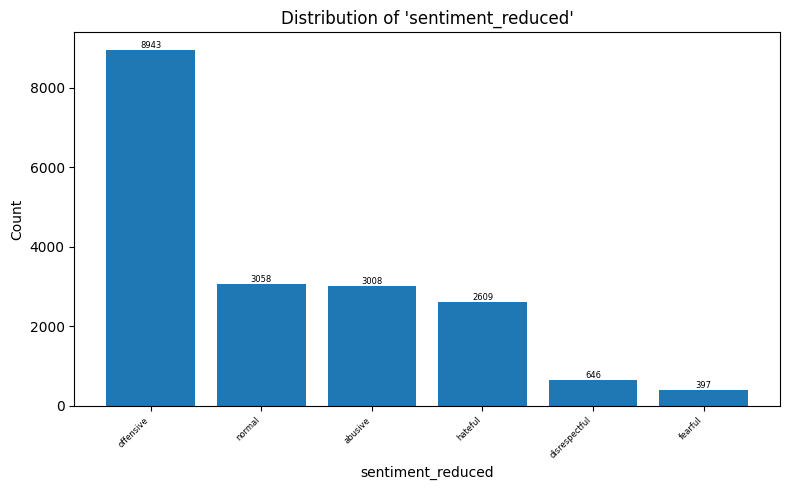

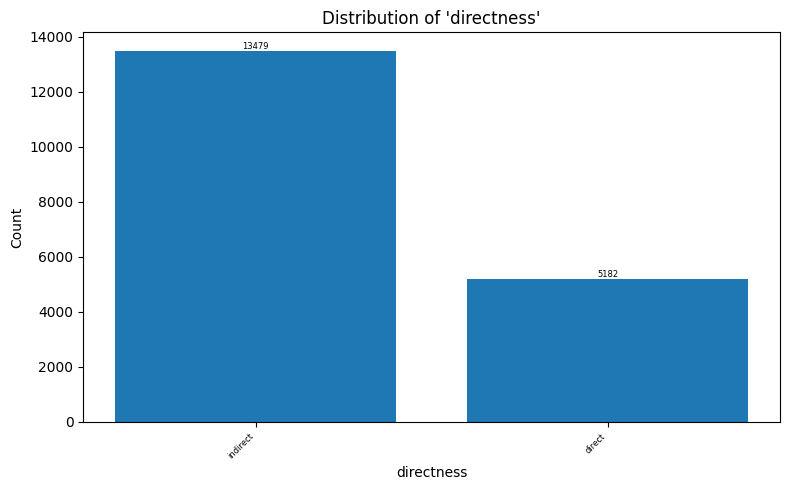

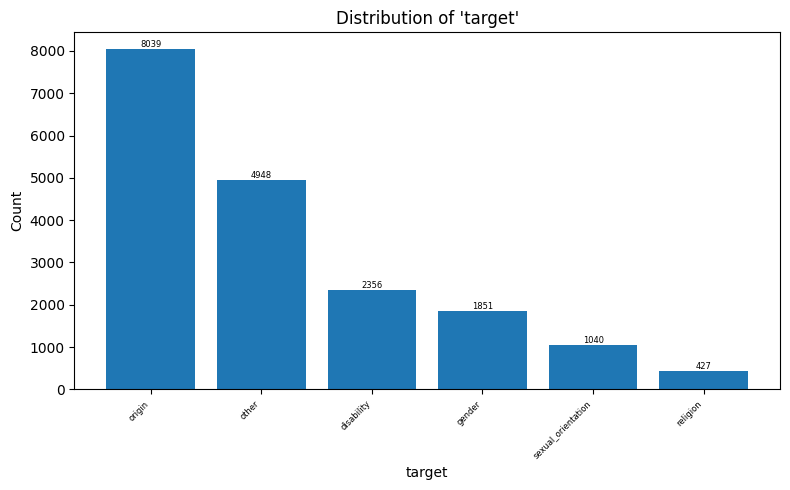

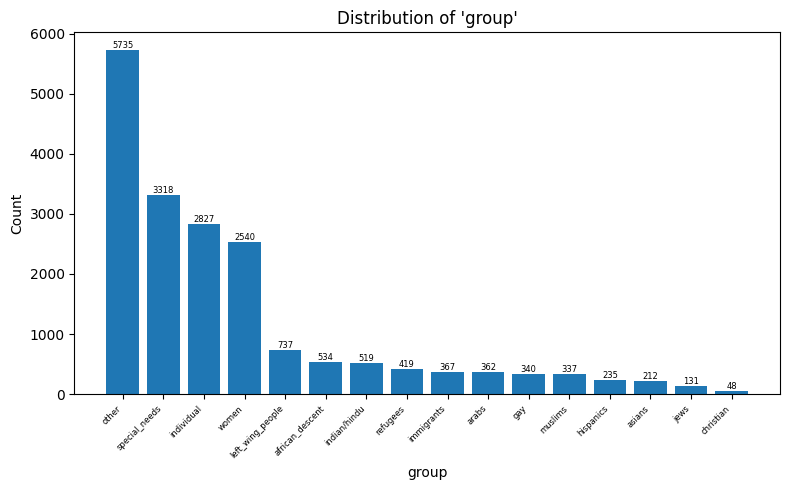

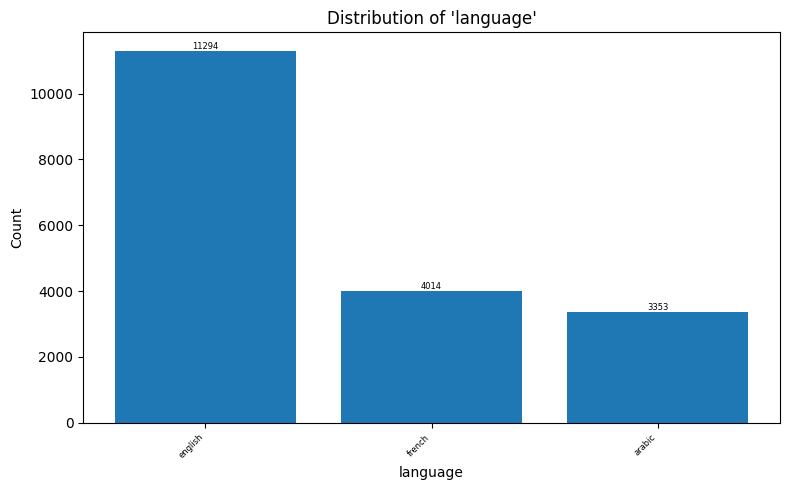

In [202]:
def plot_distribution(column):
    directness_counts = train[column].value_counts()
    plt.figure(figsize=(8, 5))
    bars = plt.bar(directness_counts.index.astype(str), directness_counts.values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f"Distribution of '{column}'")
    plt.xticks(rotation=45, ha='right', fontsize=6)

    # Add value labels on top of bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())),
                ha='center', va='bottom', fontsize=6)

    plt.tight_layout()
    plt.show()

plot_distribution('sentiment')
plot_distribution('sentiment_reduced')
plot_distribution('directness')
plot_distribution('target')
plot_distribution('group')
plot_distribution('language')

## Correlations and Co-occurrences

                           sentiment_encoded  sentiment_reduced_encoded  \
sentiment_encoded                   1.000000                   0.906851   
sentiment_reduced_encoded           0.906851                   1.000000   
directness_encoded                  0.249796                   0.202221   
target_encoded                     -0.022988                  -0.040224   
group_encoded                       0.074060                   0.068293   
language_encoded                   -0.092851                  -0.047198   

                           directness_encoded  target_encoded  group_encoded  \
sentiment_encoded                    0.249796       -0.022988       0.074060   
sentiment_reduced_encoded            0.202221       -0.040224       0.068293   
directness_encoded                   1.000000       -0.067544       0.210119   
target_encoded                      -0.067544        1.000000      -0.254099   
group_encoded                        0.210119       -0.254099       1.0000

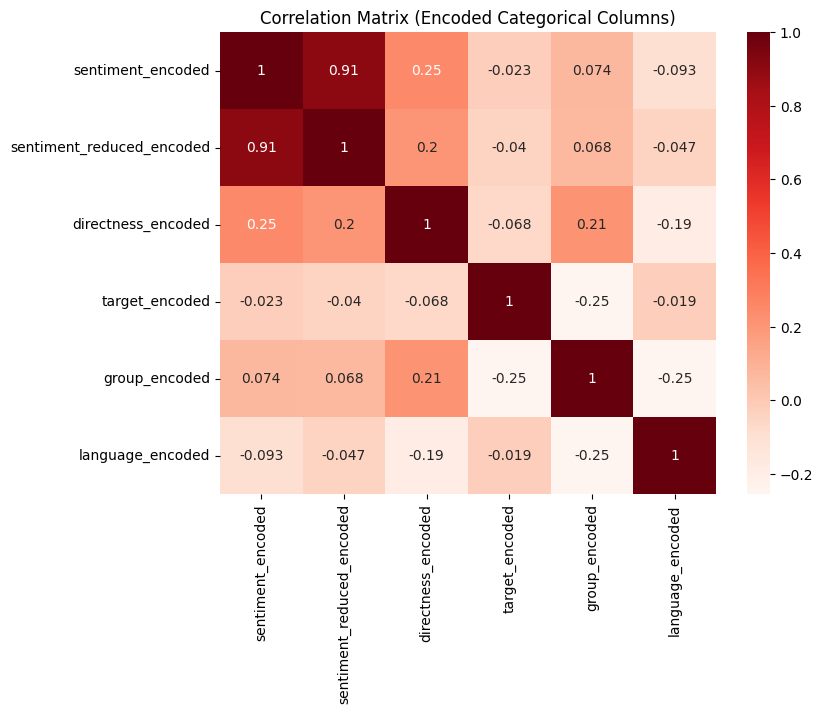

In [204]:
# Label encode the 5 categorical columns
categorical_cols = ['sentiment', 'sentiment_reduced', 'directness', 'target', 'group', 'language']
for col in categorical_cols:
    le = LabelEncoder()
    train[col + '_encoded'] = le.fit_transform(train[col].astype(str))

# Create a DataFrame with only the encoded columns
encoded_df = train[[col + '_encoded' for col in categorical_cols]]

# Show correlation matrix for the encoded categorical columns
correlation_matrix = encoded_df.corr()
print(correlation_matrix)

# Optional: visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds')
plt.title('Correlation Matrix (Encoded Categorical Columns)')
plt.show()

Sentiment Cooccurrences


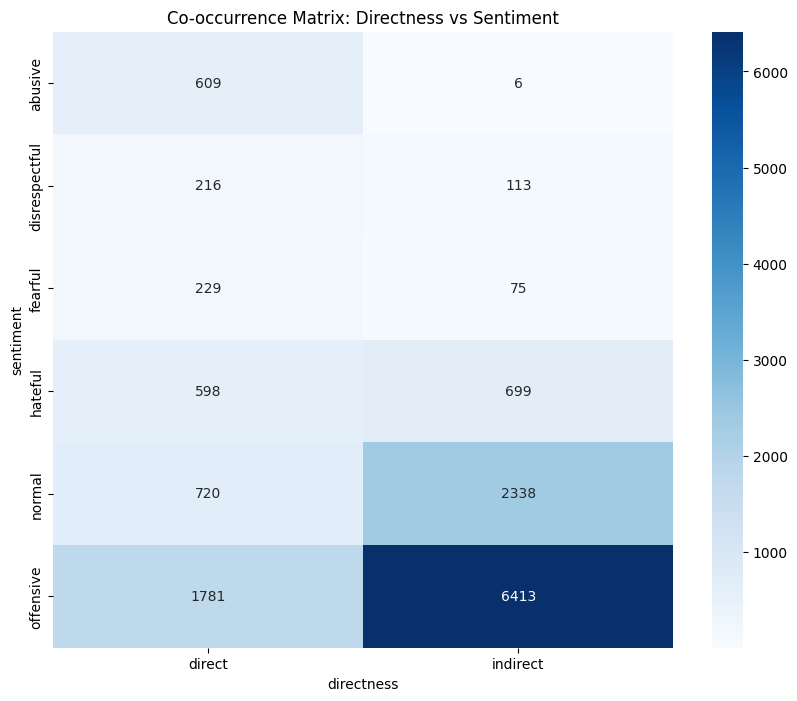

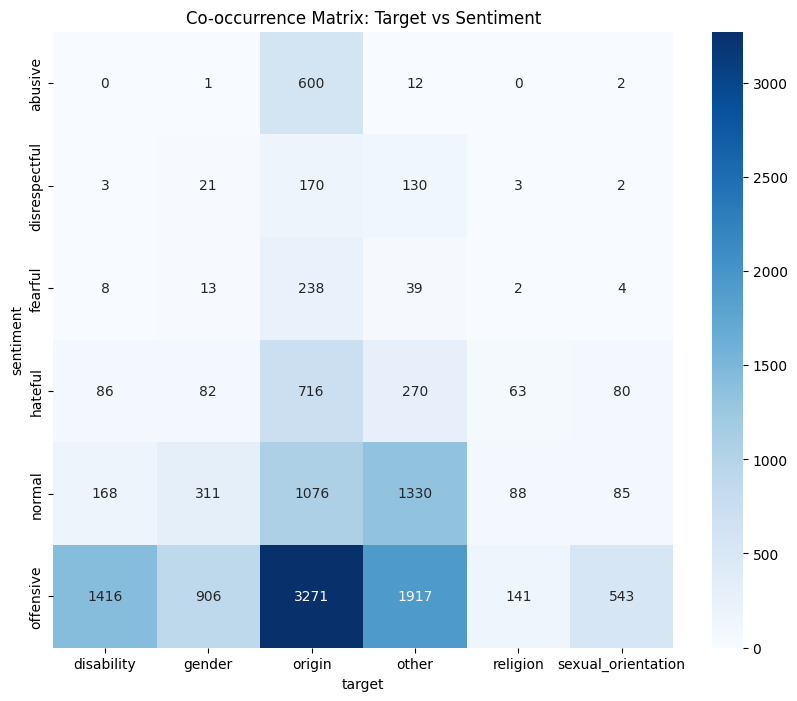

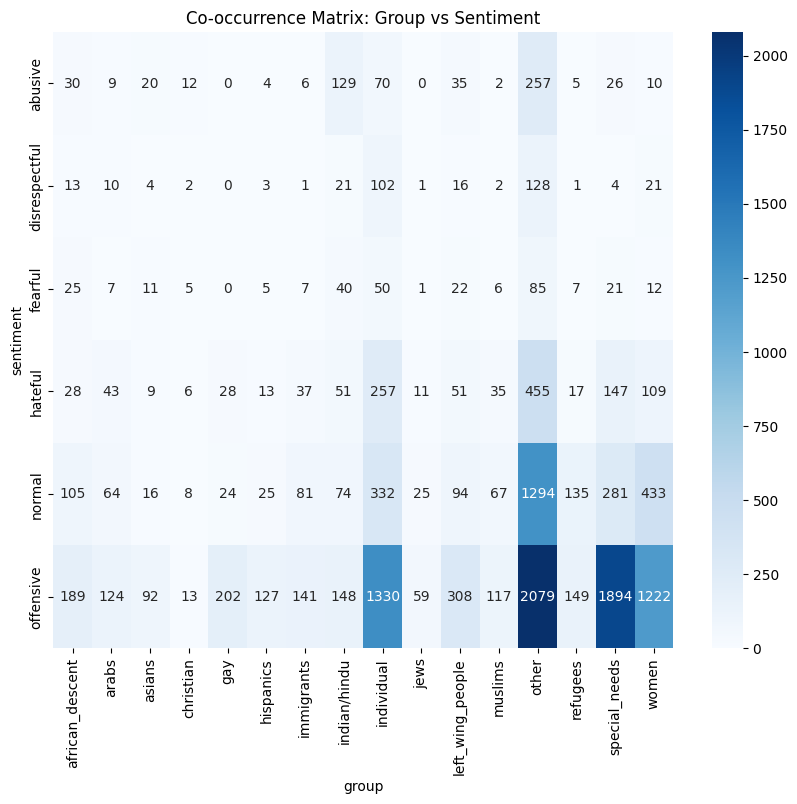


Language Cooccurrences


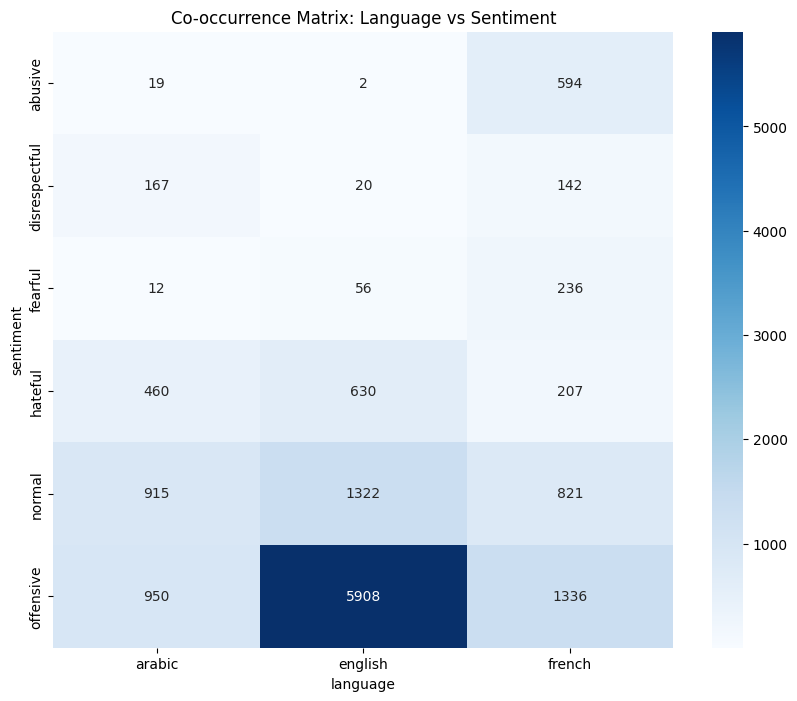

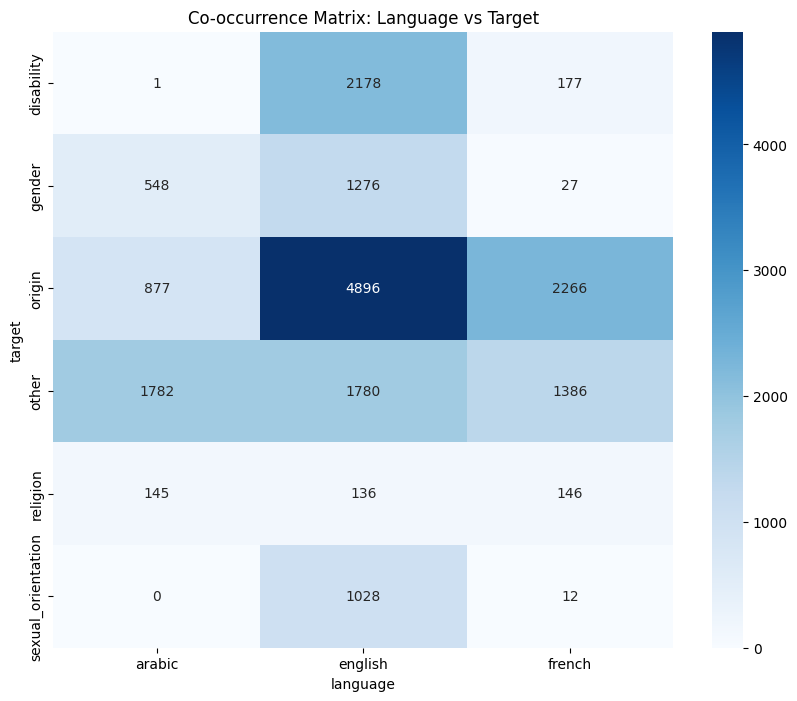

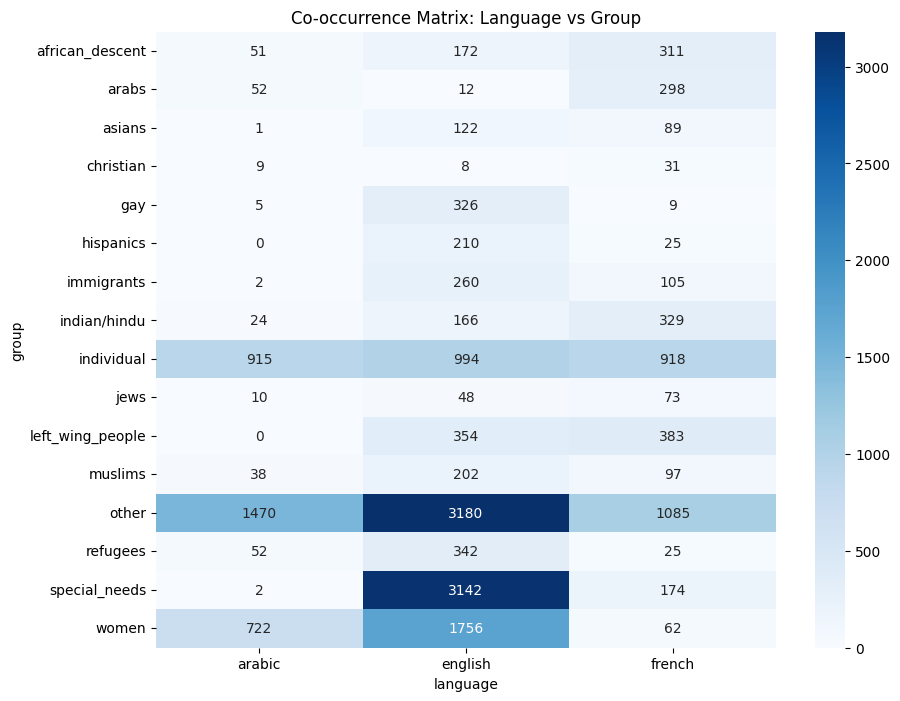


Directness Cooccurrences


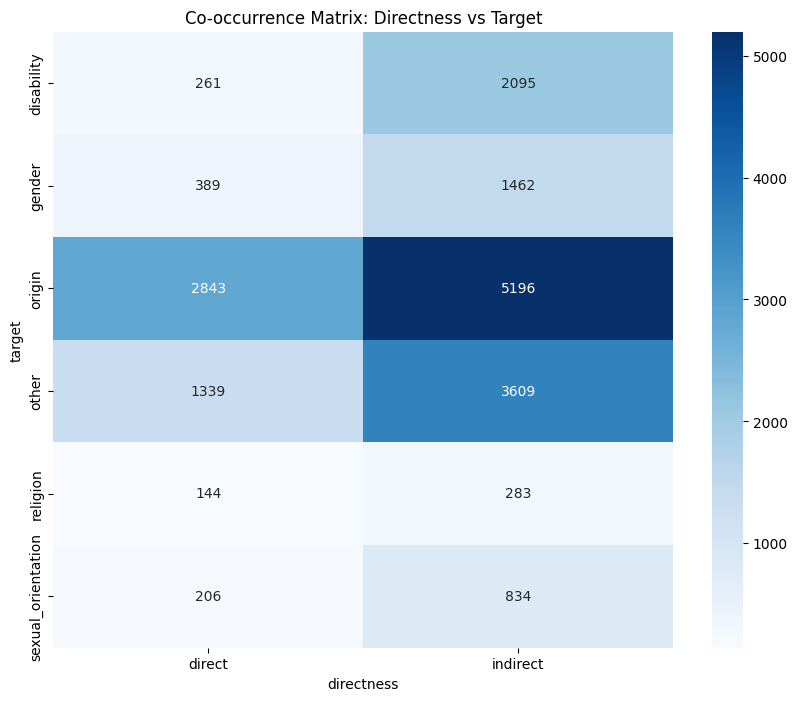

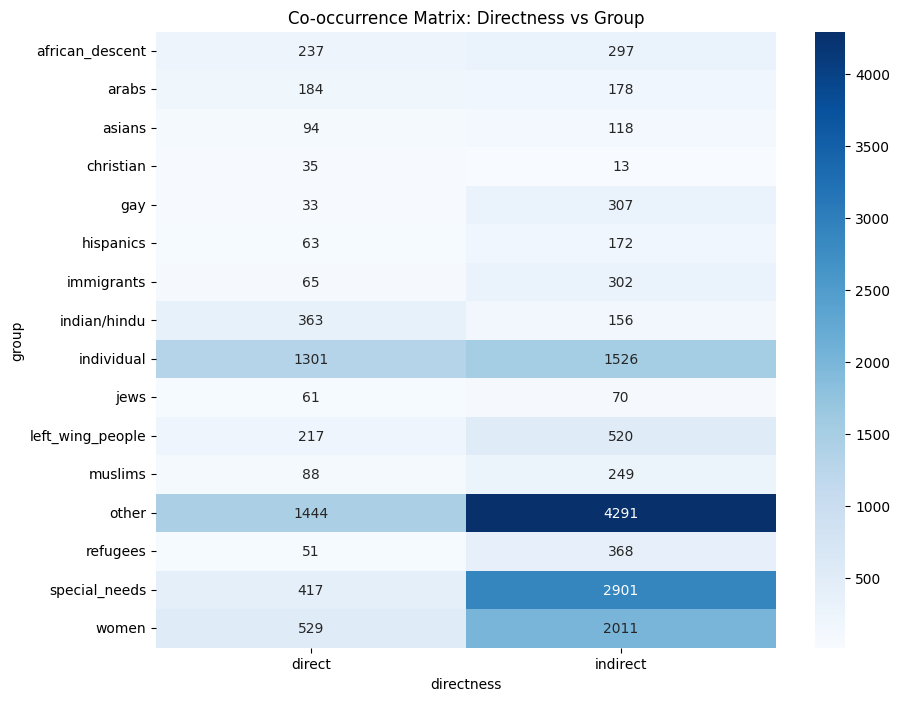

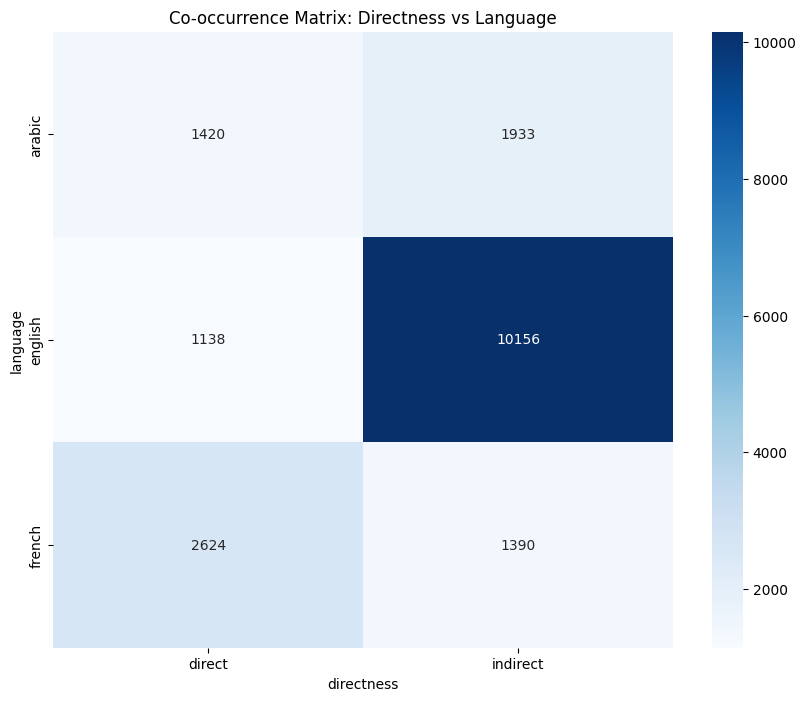


Group vs. Target


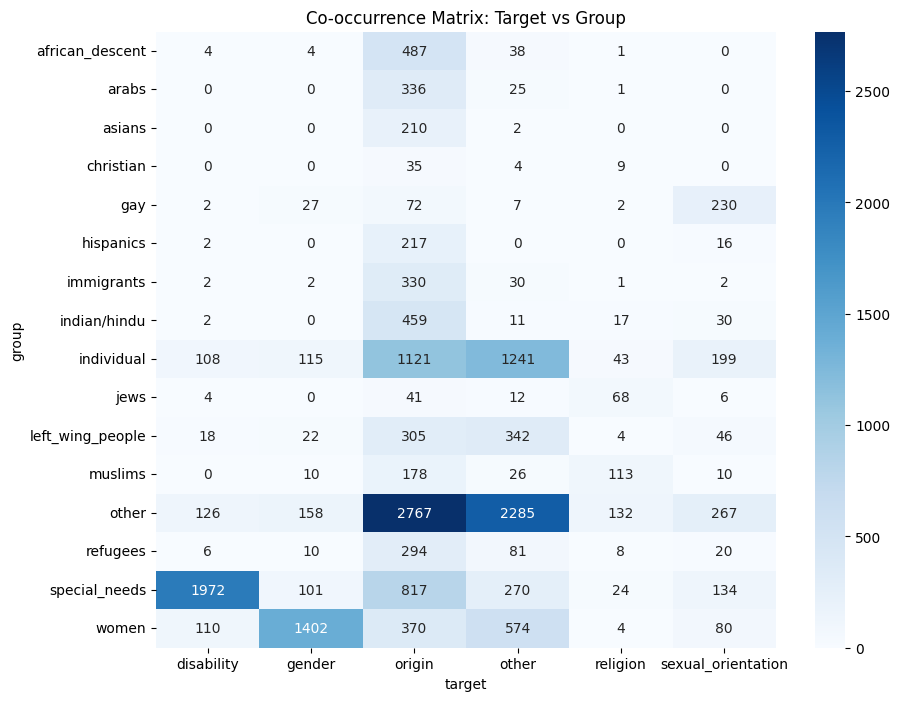

In [205]:
def plot_cooccurrence_matrix(col1, col2, col1_name, col2_name):
    cooccurrence = pd.crosstab(
        train[col1_name], train[col2_name]
    ).reindex(index=col1, columns=col2, fill_value=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Co-occurrence Matrix: {col2_name.title()} vs {col1_name.title()}')
    plt.xlabel(col2_name)
    plt.ylabel(col1_name)
    plt.xticks()
    plt.yticks()
    plt.show()

# sentiments = ['normal', 'offensive', 'hateful', 'abusive', 'disrespectful', 'fearful']
sentiments = sorted(train['sentiment_reduced'].unique())
directness = sorted(train['directness'].unique())
target = sorted(train['target'].unique())
group = sorted(train['group'].unique())
language = sorted(train['language'].unique())

print("Sentiment Cooccurrences")
plot_cooccurrence_matrix(sentiments, directness, 'sentiment', 'directness')
plot_cooccurrence_matrix(sentiments, target, 'sentiment', 'target')
plot_cooccurrence_matrix(sentiments, group, 'sentiment', 'group')
print("\nLanguage Cooccurrences")
plot_cooccurrence_matrix(sentiments, language, 'sentiment', 'language')
plot_cooccurrence_matrix(target, language, 'target', 'language')
plot_cooccurrence_matrix(group, language, 'group', 'language')
print("\nDirectness Cooccurrences")
plot_cooccurrence_matrix(target, directness, 'target', 'directness')
plot_cooccurrence_matrix(group, directness, 'group', 'directness')
plot_cooccurrence_matrix(language, directness, 'language', 'directness')
print("\nGroup vs. Target")
plot_cooccurrence_matrix(group, target, 'group', 'target')


## Language Differences

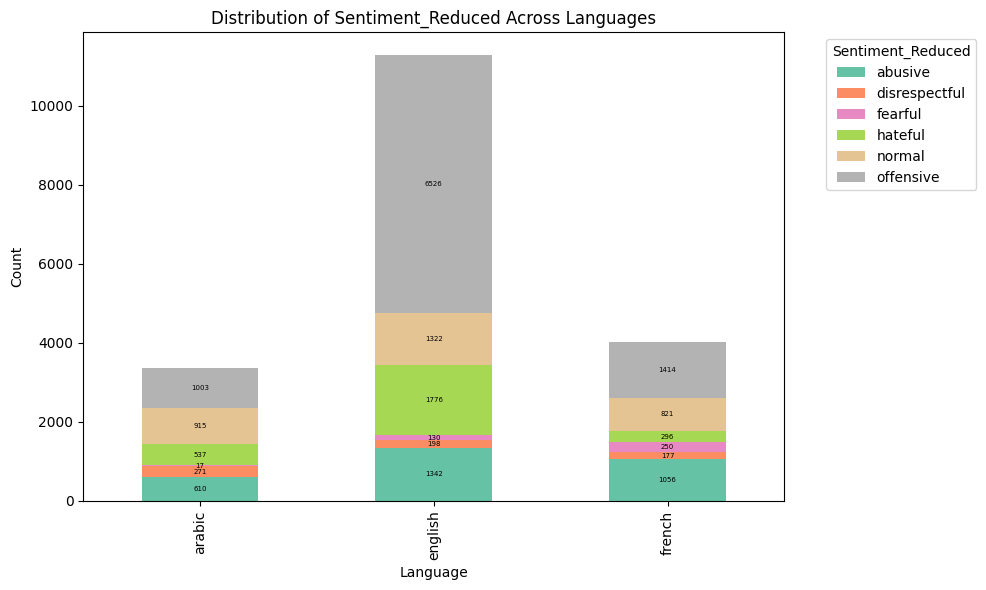

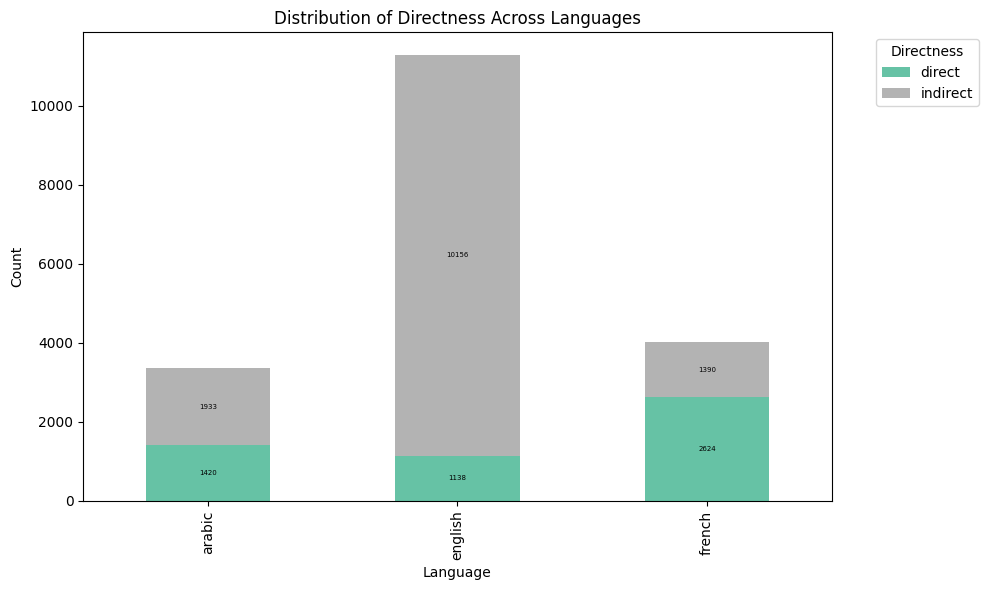

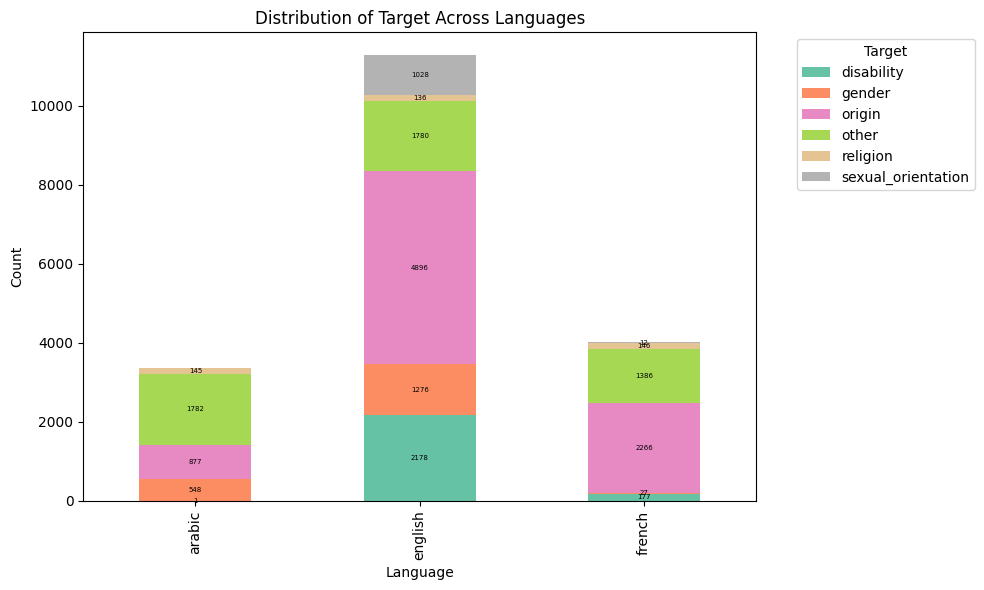

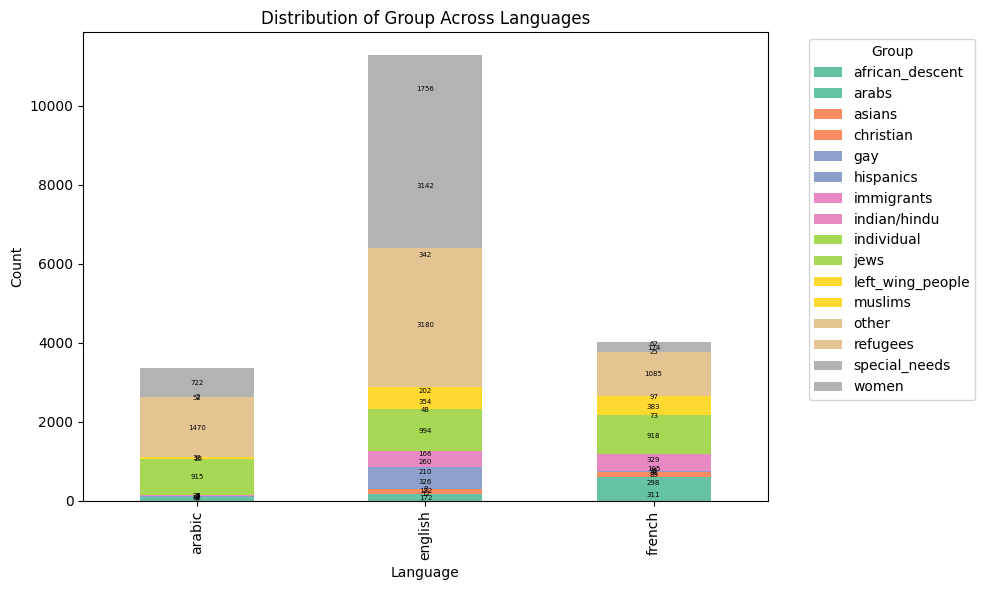

In [206]:
# Language vs. Label Distribution: Stacked Bar Plot
for label in ['sentiment_reduced', 'directness', 'target', 'group']:
    plt.figure(figsize=(10, 6))
    lang_label_counts = pd.crosstab(train['language'], train[label])
    if label == 'sentiment':
        # Restrict columns to only the specified sentiments, fill missing with 0
        sentiments = ['normal', 'offensive', 'hateful', 'abusive', 'disrespectful', 'fearful']
        lang_label_counts = lang_label_counts.reindex(columns=sentiments, fill_value=0)
    ax = lang_label_counts.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10,6), ax=plt.gca())
    plt.title(f'Distribution of {label.title()} Across Languages')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.legend(title=label.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # Add value counts on top of each bar segment
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}',
                            (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                            ha='center', va='center', fontsize=5, color='black')

    plt.show()


In [371]:
# Show a few sample texts per class per language
def show_samples_per_class_per_language(column, n=3):
    print(f"\nSample texts for each {column} per language:")
    for lang in train['language'].dropna().unique():
        print(f"\n=== Language: {lang} ===")
        if column == 'sentiment':
            classes = ['normal', 'offensive', 'hateful', 'abusive', 'disrespectful', 'fearful']
        else:
            classes = train[column].dropna().unique()
        for cls in classes:
            print(f"\n--- {column.title()}: {cls} ---")
            samples = train[(train['language'] == lang) & (train[column] == cls)]['tweet_cleaned'].dropna().head(n)
            if samples.empty:
                print("No samples available.")
            else:
                for i, text in enumerate(samples, 1):
                    print(f"{i}. {text}")

In [372]:
show_samples_per_class_per_language('sentiment_reduced', n=3)  


Sample texts for each sentiment_reduced per language:

=== Language: arabic ===

--- Sentiment_Reduced: hateful ---
1. صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون
2. الكردي كلب من يوم يومه بحاجة دائما لسيد وهلا اصبحتم خنازير اسرائيل بمرتبة الكلب
3. انت اكبر المشردين بايع ارضك وعرضك وتتكلم على اسيادك السعودية ي كلب ي مرتزق ي خنزير

--- Sentiment_Reduced: offensive ---
1. صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اجنبي منك لله ربنا ياخدك ي…
2. طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون .......
3. ما عارف كنت شايفها منحرفة شديد وانا صغير ليه

--- Sentiment_Reduced: normal ---
1. انا اوافقك بخصوص السوريين و العراقيين اما بخصوص السعودي مو بحاجه انه يقعد بالكويت بدو…
2. هذه السعودية التي شعبها شعب الخيم و بول البعير الذي يستهزأ بها الناس
3. صباح التوكل على الله والسعي على رزقه والثقة فيما عنده #افريقيا_يا_اهلى

--- Sentiment_Reduced: abusive ---
1. خنازير فعلت فعلاً ..
2. واحده بايره
3. اعراب همج. ايش تتوقع من شاربين بول البعير

--- 

In [373]:
show_samples_per_class_per_language('directness', n=3)  


Sample texts for each directness per language:

=== Language: arabic ===

--- Directness: indirect ---
1. صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون
2. صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اجنبي منك لله ربنا ياخدك ي…
3. طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون .......

--- Directness: direct ---
1. انا اوافقك بخصوص السوريين و العراقيين اما بخصوص السعودي مو بحاجه انه يقعد بالكويت بدو…
2. ما عارف كنت شايفها منحرفة شديد وانا صغير ليه
3. وانتي مال امك يا مطلقة يا بايرة ياوش قنوات

=== Language: english ===

--- Directness: indirect ---
1. call sis im boy girl still faggot shut
2. legit nilas retarded idk
3. said retard

--- Directness: direct ---
1. i'm oprah winfrey. oprah singing faggot
2. queue fucking retarded makes everyone feel like even chance make fcfs fucksake
3. mongoloid ordered 9 dozen donuts 8 called back see sell craft coffee

=== Language: french ===

--- Directness: indirect ---
1. bah oui t'as raison l'autr

In [374]:
show_samples_per_class_per_language('target', n=3) 


Sample texts for each target per language:

=== Language: arabic ===

--- Target: gender ---
1. صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون
2. ما عارف كنت شايفها منحرفة شديد وانا صغير ليه
3. وانتي مال امك يا مطلقة يا بايرة ياوش قنوات

--- Target: other ---
1. صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اجنبي منك لله ربنا ياخدك ي…
2. طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون .......
3. تخيل يرد عليك يقولك حسب معلوماتنا ان سكان الارض يشربون بول البعير

--- Target: origin ---
1. انا اوافقك بخصوص السوريين و العراقيين اما بخصوص السعودي مو بحاجه انه يقعد بالكويت بدو…
2. هذه السعودية التي شعبها شعب الخيم و بول البعير الذي يستهزأ بها الناس
3. الكردي كلب من يوم يومه بحاجة دائما لسيد وهلا اصبحتم خنازير اسرائيل بمرتبة الكلب

--- Target: religion ---
1. لا هندوس
2. والله هدف ما يدخل في فريق فئات سنية.. هدف ساذج يا خنازير
3. قال الشيعه الصفوين الروافض الاباضيه الاباضيه الاباضيه أنت ينجس يطقعه تتوضا بول البعي…

--- Target: disability ---
1. ا

In [375]:
show_samples_per_class_per_language('group', n=3) 


Sample texts for each group per language:

=== Language: arabic ===

--- Group: individual ---
1. صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون
2. طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون .......
3. ما عارف كنت شايفها منحرفة شديد وانا صغير ليه

--- Group: other ---
1. صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اجنبي منك لله ربنا ياخدك ي…
2. انا اوافقك بخصوص السوريين و العراقيين اما بخصوص السعودي مو بحاجه انه يقعد بالكويت بدو…
3. هذه السعودية التي شعبها شعب الخيم و بول البعير الذي يستهزأ بها الناس

--- Group: women ---
1. وانتي مال امك يا مطلقة يا بايرة ياوش قنوات
2. لكن حرمة متبرجة تقف على المسرح وتغني امام الر…
3. واضح انكم تكذبوها ع سالفه ان الحريم يقعدن بالارض ولا انا فهمت غلط ودرعمت؟

--- Group: arabs ---
1. اعراب همج. ايش تتوقع من شاربين بول البعير
2. كمن فسر الماء بالماء.. ياغبي العالم كله عرف انكم خنازير مو بس السعوديين.. رح الشبك…
3. من اللي يقول المصاريا يحبون الفلوس واللبناني قذر والتركي شايف نفسه والسوداني عجاز والعرا